In [1]:
!pip install wandb
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install scikit-learn
!pip install torch_tb_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 88.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 18.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 31.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 27.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24

In [2]:
import os

target_dir = "../"
zip_file_path = "generated.zip"

if not os.path.exists(target_dir + 'generated'):
    print(f"The directory {target_dir} does not exist. Proceeding with download.")

    !apt-get update
    !apt-get install unzip
    
    !curl "https://drive.usercontent.google.com/download?id=1_z-BLK2nlweOgRiDJXhPwsDR5qjqe9Nm&confirm=xxx" -o {zip_file_path}
    !mkdir -p {target_dir}
    
    !unzip {zip_file_path} -d {target_dir}
    
    print(f"File downloaded and extracted to {target_dir}")
    
    !rm {zip_file_path}
else:
    print(f"The directory {target_dir} already exists. No action taken.")

The directory ../ already exists. No action taken.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import wandb
import matplotlib.pyplot as plt
import torch.profiler
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
pairs = pd.read_csv('../generated/auction_indices.csv')
pairs.head()

,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
0,2024-01-04 00:00:00,12365,173,31.47,17.18,1.0,49.0,wotlk
1,2024-01-04 00:00:00,7462,1,49.00,0.00,49.0,49.0,wotlk
2,2024-01-04 00:00:00,20950,63,35.49,12.16,14.0,49.0,wotlk
3,2024-01-04 00:00:00,9681,23,48.00,4.91,25.0,50.0,wotlk
4,2024-01-04 00:00:00,36907,947,45.20,9.82,1.0,50.0,wotlk


## Prepare and balance data

In [5]:
pd.options.display.float_format = '{:.2f}'.format
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00
mean,25211.34,14.34,34.36,6.42,25.85,42.76
std,17112.51,54.68,18.28,6.57,20.89,18.62
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10184.00,1.00,25.00,0.00,13.00,25.00
50%,23782.00,3.00,31.64,5.70,25.00,49.00
75%,39909.00,8.00,46.00,12.00,33.00,49.00
max,232031.00,5008.00,164.00,79.50,164.00,164.00


In [6]:
pairs[['group_len']].quantile(0.99)

group_len   212.00
Name: 0.99, dtype: float64

In [7]:
pairs = pairs[pairs['group_max'] < 50]
pairs = pairs[pairs['group_len'] < 64]
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,11252388.00,11252388.00,11252388.00,11252388.00,11252388.00,11252388.00
mean,25058.82,6.89,32.57,5.94,24.89,40.09
std,17098.63,10.16,12.15,6.26,15.23,12.73
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10180.00,1.00,25.00,0.00,13.00,25.00
50%,23629.00,3.00,31.00,4.72,25.00,49.00
75%,39086.00,7.00,45.22,11.76,30.00,49.00
max,232031.00,63.00,49.00,24.50,49.00,49.00


In [8]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42, shuffle=False)

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

val_pairs.head()

Train pairs: 10127149
Val pairs: 1125239


,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
11414845,2024-08-14 14:00:00,14794,1,49.00,0.00,49.00,49.00,cata
11414846,2024-08-14 14:00:00,15233,2,37.00,12.00,25.00,49.00,cata
11414847,2024-08-14 14:00:00,15641,1,49.00,0.00,49.00,49.00,cata
11414848,2024-08-14 14:00:00,10228,1,49.00,0.00,49.00,49.00,cata
11414849,2024-08-14 14:00:00,14899,1,49.00,0.00,49.00,49.00,cata


In [9]:
train_pairs_wotlk = train_pairs[train_pairs['expansion'] == 'wotlk']

rows_to_delete = train_pairs_wotlk.sample(n=int(len(train_pairs_wotlk) * 0.85)).index
train_pairs = train_pairs.drop(rows_to_delete)

expansion
wotlk    1346662
cata     1149407
Name: count, dtype: int64


<Axes: xlabel='expansion'>

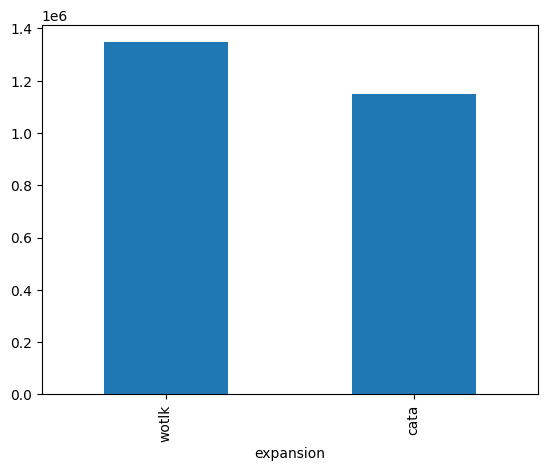

In [10]:
print(train_pairs.expansion.value_counts())

train_pairs.expansion.value_counts().plot(kind='bar')

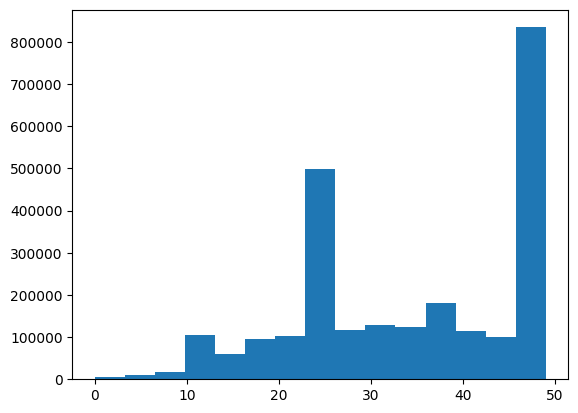

In [11]:
plt.hist(train_pairs['group_mean'], bins=15)
plt.show()

/tmp/ipykernel_1525/522571171.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bins)


Train pairs: 1321753


<Axes: >

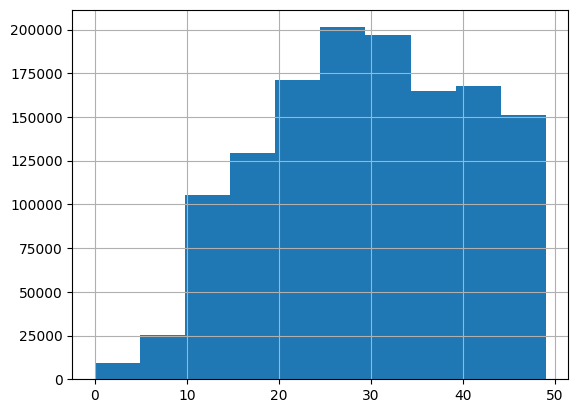

In [12]:
def uniform_sample(df, column, n_samples):
    bins = pd.cut(df[column], bins=48)

    grouped = df.groupby(bins)

    samples_per_bin = n_samples // len(grouped)
    remainder = n_samples % len(grouped)

    sampled_df = pd.DataFrame()
    for _, group in grouped:
        if len(group) > samples_per_bin:
            sample = group.sample(n=samples_per_bin, replace=False)
        else:
            sample = group
        sampled_df = pd.concat([sampled_df, sample])

    if remainder > 0:
        additional_sample = df.sample(n=remainder, replace=False)
        sampled_df = pd.concat([sampled_df, additional_sample])

    return sampled_df.sample(frac=1).reset_index(drop=True)  # Shuffle the final result

train_pairs = uniform_sample(train_pairs, 'group_mean', n_samples=int(len(train_pairs)))
print(f"Train pairs: {len(train_pairs)}")
train_pairs.group_mean.hist(bins=10)

In [13]:
items = pd.read_csv('../data/items.csv')
n_items = len(items)

item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0 # padding
item_to_index[1] = 1 # unknown
n_items

11655

## Preprocess data

In [14]:
import torch
from datetime import datetime

class AuctionDataset(torch.utils.data.Dataset):

    def __init__(self, pairs, item_to_index, path='sequences'):
        self.pairs = pairs
        self.column_map = {
            'bid': 0,
            'buyout': 1,
            'quantity': 2,
            'item_id': 3,
            'time_left': 4,
            'hours_since_first_appearance': 5
        }
        self.item_to_index = item_to_index
        self.path = path

        print(f"Dataset size: {len(self)}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]

        record = pair['record']
        item_id = pair['item_id']

        # Parse the record timestamp
        date_time_obj = datetime.strptime(record, "%Y-%m-%d %H:%M:%S")
        date_folder_name = date_time_obj.strftime("%Y-%m-%d")
        hour_folder_name = date_time_obj.strftime("%H")

        file_path = f'{self.path}/{date_folder_name}/{hour_folder_name}.pt'

        data = torch.load(file_path)
        X = torch.tensor(data[item_id])

        y = X[:, -1] - X[:, self.column_map['hours_since_first_appearance']]
        X = X[:, :-1]

        X[:, self.column_map['item_id']] = torch.tensor([self.item_to_index.get(int(item), 1) for item in X[:, self.column_map['item_id']]], dtype=torch.long)
        X[:, self.column_map['time_left']] = X[:, self.column_map['time_left']] / 48.0
        X[:, self.column_map['hours_since_first_appearance']] = X[:, self.column_map['hours_since_first_appearance']] / 48.0
        X[:, self.column_map['bid']] = torch.log1p(X[:, self.column_map['bid']]) / 15.0
        X[:, self.column_map['buyout']] = torch.log1p(X[:, self.column_map['buyout']]) / 15.0
        X[:, self.column_map['quantity']] = X[:, self.column_map['quantity']] / 200.0

        return X, y

In [15]:
def collate_auctions(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    X, y = zip(*batch)

    lengths = torch.LongTensor([x.size(0) for x in X])

    max_length = lengths.max()

    X = [F.pad(x, (0, 0, 0, max_length - x.size(0))) for x in X]
    y = [F.pad(x, (0, max_length - x.size(0))) for x in y]

    X = torch.stack(X)
    y = torch.stack(y)

    return X, y, lengths

## Model definition

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, input_size=5, item_index=3, embedding_size=16, hidden_size=16, dropout_p=0.1, bidirectional=True):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.item_index = item_index
        n_items = len(item_to_index)

        self.embedding = nn.Embedding(n_items, embedding_size)
        self.rnn = nn.GRU(input_size + embedding_size, hidden_size, batch_first=True, num_layers=2, bidirectional=bidirectional, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X, lengths):
        item_ids = X[:, :, self.item_index].long()
        X = torch.cat([X[:, :, :self.item_index], X[:, :, self.item_index + 1:]], dim=2)
        item_embeddings = self.dropout(self.embedding(item_ids))

        X = torch.cat([X, item_embeddings], dim=2)
        X_packed = pack_padded_sequence(X, lengths, batch_first=True, enforce_sorted=False)

        output_packed, hidden = self.rnn(X_packed)

        return output_packed, hidden


class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, bidirectional=True, dropout_p=0.1):
        super(Decoder, self).__init__()
        output_size = hidden_size * 2 if bidirectional else hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=bidirectional, dropout=dropout_p)
        self.projection = nn.Sequential(
            nn.Linear(output_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, encoder_outputs, encoder_hidden):
        output_packed, _ = self.rnn(encoder_outputs, encoder_hidden)

        output, _ = pad_packed_sequence(output_packed, batch_first=True)
        output = self.projection(output)

        return output


class AuctionPredictor(nn.Module):
    def __init__(self, input_size=5, encoder_hidden_size=16, decoder_hidden_size=16, item_index=3, embedding_size=16, dropout_p=0.1, bidirectional=True):
        super(AuctionPredictor, self).__init__()
        decoder_input_size = encoder_hidden_size * 2 if bidirectional else encoder_hidden_size
        self.encoder = Encoder(input_size, item_index, embedding_size, encoder_hidden_size, dropout_p, bidirectional=bidirectional)
        self.decoder = Decoder(decoder_input_size, decoder_hidden_size, bidirectional=bidirectional, dropout_p=dropout_p)

    def forward(self, X, lengths):
        encoder_outputs, encoder_hidden = self.encoder(X, lengths)
        decoder_outputs = self.decoder(encoder_outputs, encoder_hidden)
        return decoder_outputs

In [17]:
train_dataset = AuctionDataset(train_pairs, item_to_index, path='../generated/sequences')
val_dataset = AuctionDataset(val_pairs, item_to_index, path='../generated/sequences')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_auctions)#, num_workers=8, prefetch_factor=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_auctions)#, num_workers=8, prefetch_factor=8)

# Test dataloader
iter_loader = iter(train_dataloader)
X, y, lengths = next(iter_loader)

print(X.shape)
print(y.shape)

Dataset size: 1321753
Dataset size: 1125239
torch.Size([128, 62, 6])
torch.Size([128, 62])


In [18]:
embedding_size = 256
encoder_hidden_size = 512
decoder_hidden_size = 512
epochs = 1
save_every_iters = 2500
dropout = 0.1
bidirectional = False

model = AuctionPredictor(input_size=5,
                         encoder_hidden_size=encoder_hidden_size,
                         decoder_hidden_size=decoder_hidden_size,
                         item_index=3,
                         embedding_size=embedding_size,
                         dropout_p=dropout,
                         bidirectional=bidirectional
                         ).to(device)

print(sum(p.numel() for p in model.parameters()))

load_checkpoint = False

if load_checkpoint:
  checkpoint = torch.load('checkpoints/checkpoint_epoch_4.pt')
  model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
total_steps = len(train_dataloader) * epochs
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True)
criterion = nn.MSELoss(reduction='sum')

print(f'Iterations per epoch: {len(train_dataloader)}')

8937345
Iterations per epoch: 10327


In [19]:
enable_logging = False

if enable_logging:
  print("Logging enabled")
  wandb.init(project="auction-classic", config={
      "epochs": epochs,
      "batch_size": train_dataloader.batch_size,
      "learning_rate": optimizer.param_groups[0]['lr'],
      "encoder_hidden_size": encoder_hidden_size,
      "decoder_hidden_size": decoder_hidden_size,
      "model_size": sum(p.numel() for p in model.parameters()),
      "embedding_size": embedding_size,
      "bidirectional": bidirectional,
      "dropout": dropout
  })
else:
  print("Logging disabled")
  wandb.init(mode="disabled")

Logging disabled


## Training

In [20]:
def save_checkpoint(model, optimizer, epoch, iters, checkpoint_path='checkpoints'):
    os.makedirs(checkpoint_path, exist_ok=True)
    checkpoint_file = os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch}_iter_{iters}.pt")
    torch.save({
        'epoch': epoch,
        'iter': iters,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)
    print(f"Checkpoint saved at {checkpoint_file}")

def train(
    model,
    train_loader,
    val_loader,
    epochs,
    eval_steps,
    device,
    optimizer,
    criterion,
    lr_scheduler
):
    print("Starting training for", epochs, "epochs")

    with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=4, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/auctions'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for epoch in tqdm(range(epochs)):
            model.train()
    
            mse_losses = []
            mae_losses = []
            
            for i, (X, y, lengths) in enumerate(tqdm(train_loader, total=len(train_loader))):
                prof.step()

                if i >= (1 + 4 + 3) * 1:
                    print('Stop profiler')
                    break
                
                X = X.to(device)
                y = y.to(device)
    
                y_pred = model(X, lengths)
                mask = (y != 0).float().unsqueeze(2)
    
                loss = criterion(y_pred * mask, y.unsqueeze(2)) / mask.sum()
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
                optimizer.step()
                optimizer.zero_grad()
    
                with torch.no_grad():
                    mae = F.l1_loss(y_pred * mask, y.unsqueeze(2) * mask, reduction='sum') / mask.sum()
    
                mse_losses.append(loss.item())
                mae_losses.append(mae.item())
    
                if i % 50 == 0:
                    mse_loss_avg = np.mean(mse_losses)
                    mae_loss_avg = np.mean(mae_losses)
                    lr = optimizer.param_groups[0]['lr']#lr_scheduler.get_last_lr()[0]
                    print(f"Epoch {epoch} Iteration {i} Loss {mse_loss_avg} MAE {mae_loss_avg} LR {lr}")
                    lr_scheduler.step(mse_loss_avg)
    
                    wandb.log({
                      "train/mse_loss": mse_loss_avg,
                      "train/mae_loss": mae_loss_avg,
                      "train/learning_rate": lr,
                      "epoch": epoch,
                      "iter": i
                    })
    
                    mse_losses = []
                    mae_losses = []
    
                if (i + 1) % eval_steps == 0:
                  val_loss, val_mae = evaluate(model, val_loader, device, criterion)
                  wandb.log({
                    "val/mse_loss": val_loss,
                    "val/mae_loss": val_mae,
                    "epoch": epoch
                  })
    
                if (i + 1) % save_every_iters == 0:
                  save_checkpoint(model, optimizer, epoch, i)
    
            save_checkpoint(model, optimizer, epoch, len(train_loader))
    
    wandb.finish()

@torch.no_grad()
def evaluate(
    model,
    val_loader,
    device,
    criterion
):
    print("Evaluating model")
    model.eval()

    mse_losses = []
    mae_losses = []

    for i, (X, y, lengths) in enumerate(val_loader):

      if i >= 300:
        break

      if i % 15 == 0:
        print(f"Evaluating step {i}")

      X = X.to(device)
      y = y.to(device)

      y_pred = model(X, lengths)

      mask = (y != 0).float().unsqueeze(2)
      loss = criterion(y_pred * mask, y.unsqueeze(2)) / mask.sum()
      mae = F.l1_loss(y_pred * mask, y.unsqueeze(2) * mask, reduction='sum') / mask.sum()

      mse_losses.append(loss.item())
      mae_losses.append(mae.item())

      if i % 25 == 0:
        print(f"Evaluating step {i}")
        print(y[0][:10])
        print(y_pred[0,:, 0][:10])

    mse_loss_avg = np.mean(mse_losses)
    mae_loss_avg = np.mean(mae_losses)

    print(f"Validation loss: {mse_loss_avg} MAE: {mae_loss_avg}")
    model.train()

    return mse_loss_avg, mae_loss_avg

train(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    eval_steps=250,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    lr_scheduler=lr_scheduler
)

Starting training for 1 epochs


  0%|          | 1/10327 [00:24<69:28:51, 24.22s/it]

Epoch 0 Iteration 0 Loss 435.1996765136719 MAE 16.64814567565918 LR 0.0003



  0%|          | 4/10327 [01:40<71:31:14, 24.94s/it]STAGE:2024-10-21 16:09:35 1525:1525 ActivityProfilerController.cpp:312] Completed Stage: Warm Up

  0%|          | 5/10327 [02:03<69:56:24, 24.39s/it][W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event

  0%|          | 7/10327 [02:50<68:19:15, 23.83s/it]STAGE:2024-10-21 16:10:47 1525:1525 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-10-21 16:10:47 1525:1525 ActivityProfilerController.cpp:322] Completed Stage: Post Processing

  0%|          | 8/10327 [03:50<82:26:01, 28.76s/it]

Stop profiler



100%|██████████| 1/1 [03:50<00:00, 230.31s/it]

Checkpoint saved at checkpoints/checkpoint_epoch_0_iter_10327.pt


In [ ]:
wandb.finish()

## Inference

In [ ]:
torch.set_printoptions(sci_mode=False)

In [ ]:
X[:, val_dataset.column_map['bid']] = X[:, val_dataset.column_map['bid']] / 1000
X[:, val_dataset.column_map['buyout']] = X[:, val_dataset.column_map['buyout']] / 1000

print(X)

pred = model(X.unsqueeze(0).to('cpu'))

X[:, val_dataset.column_map['bid']] = X[:, val_dataset.column_map['bid']] * 1000
X[:, val_dataset.column_map['buyout']] = X[:, val_dataset.column_map['buyout']] * 1000
X[:, val_dataset.column_map['quantity']] = X[:, val_dataset.column_map['quantity']] * 200
X[:, val_dataset.column_map['hours_since_first_appearance']] = X[:, val_dataset.column_map['hours_since_first_appearance']] * 48
X[:, val_dataset.column_map['time_left']] = X[:, val_dataset.column_map['time_left']] * 48

print(X)
print(y)

print(pred)

In [ ]:
index_to_item = {i + 2: item_id for i, item_id in enumerate(items['item_id'])}
index_to_item[0] = 0
index_to_item[1] = 1

print(index_to_item.get(7631))